# 프로젝트 - Movielens 영화 SBR

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 준비

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


1. 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

2. Rating 정보가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

3. Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

In [3]:
#추천시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저수(세션 수)와 아이템 수 입니다.
data['UserId'].nunique(),data['ItemId'].nunique()

(6040, 3706)

## Session Length
session_length란 해당 세션의 사용자가 그 세션 동안 몇번의 액션을 취했는지 (이번 프로젝트에서는 어떤 영화를 몇 번이나 클릭했는지)확인할 수 있는 구분자 역할을 한다.


In [4]:
#각 세션이 대략 몇 개의 클릭 데이터를 갖는지도 살펴보겠습니다.
session_length = data.groupby('UserId').size()#자료의 크기
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
#중간값과 평균값을 찾아봅니다.
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [6]:
#최소값과 최대값을 찾아봅니다
session_length.min(),session_length.max()

(20, 2314)

In [7]:
#백분위수(Percentile)
session_length.quantile(0.999)

1343.181000000005

많은 유저들이 96~165 개 사이의 영화를 봤다.
99.9% 유저가 1343아래의 영화를 봤다.
최대값이 2314인 유저를 살펴본다. 많은 영화를 본걸까요

In [8]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


세션길이 기준 하위 99.9% 까지의 분포 누적합을 시각화해보겠습니다.

In [9]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum()/length_count.sum()#누적 합 (cumulative sums) : cumsum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]
length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

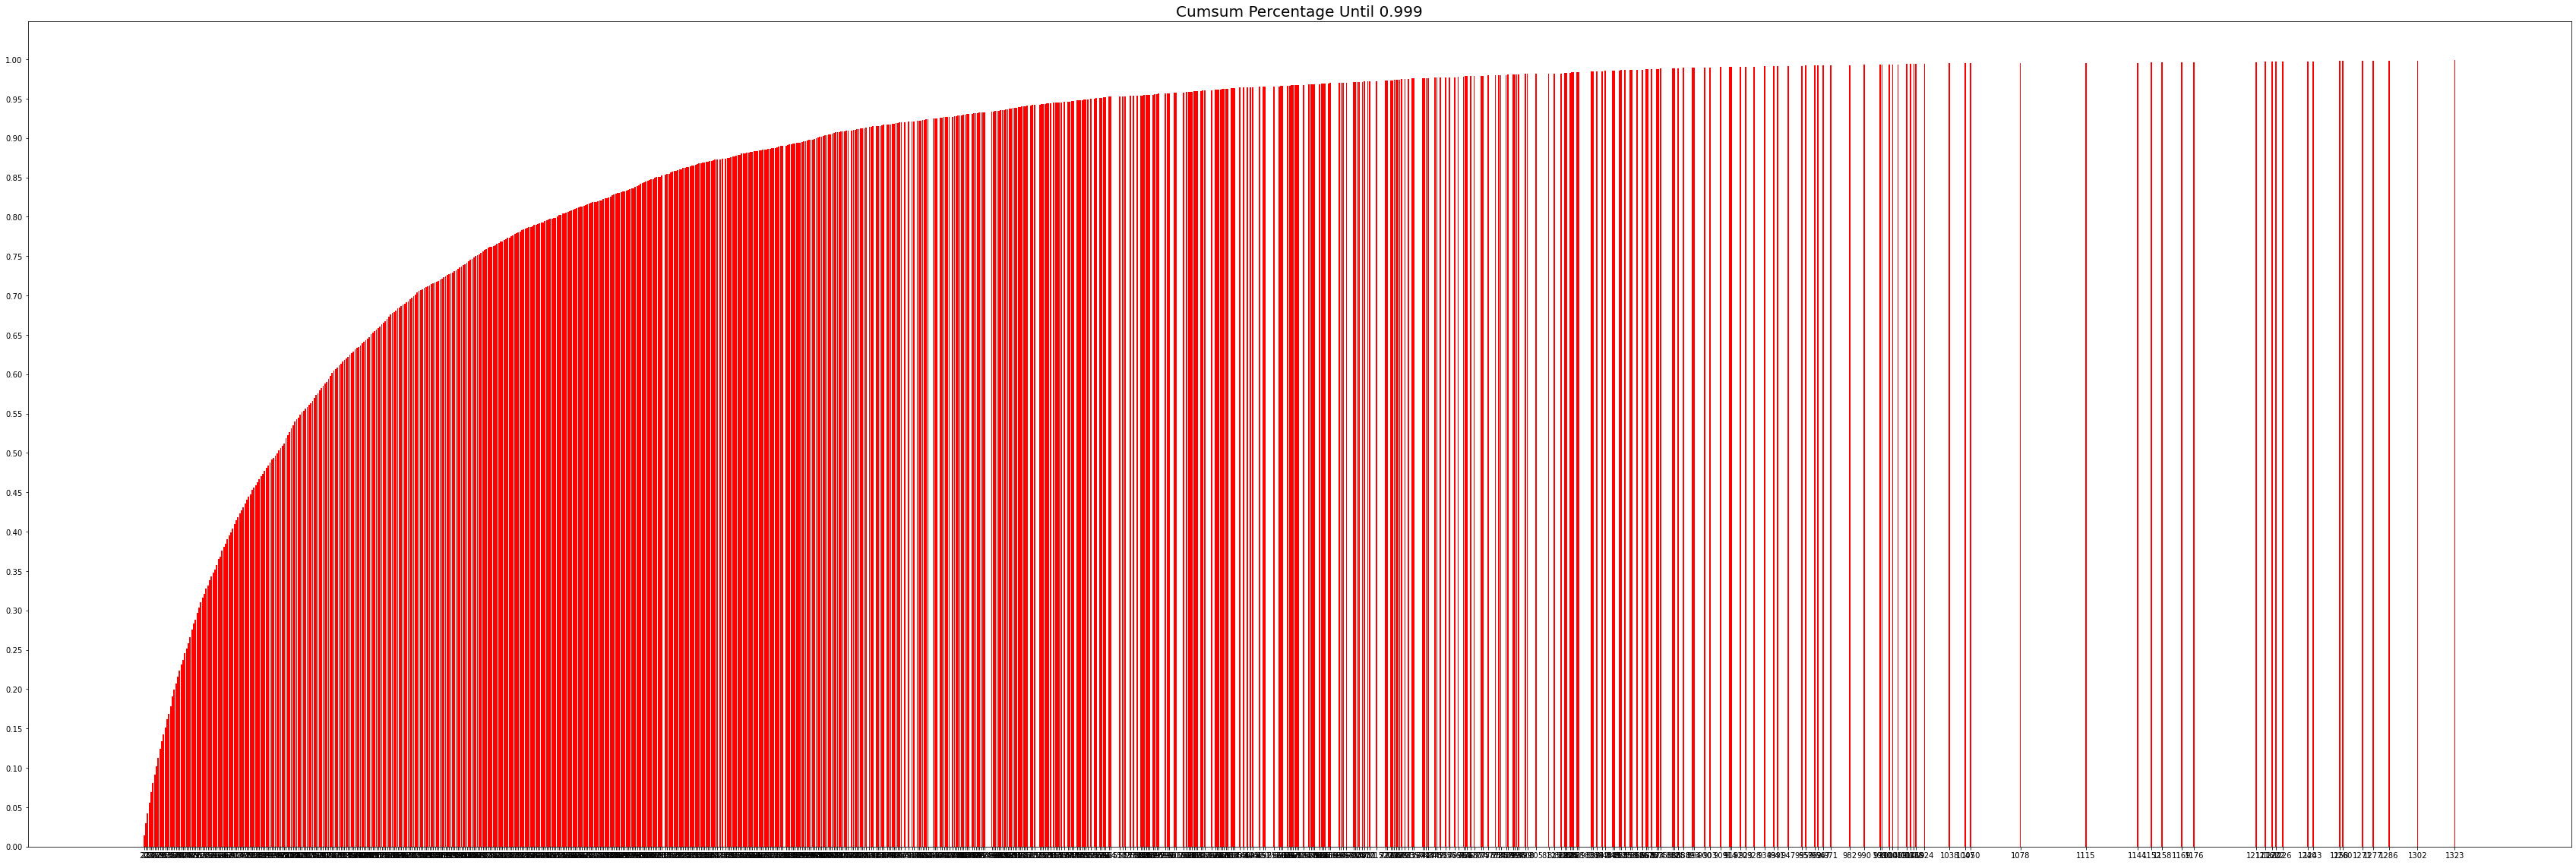

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(60, 20))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

#np arange 는 0(start) 1.01(stop) 사이에서 0.05 간격으로 눈금을 긋기위해사용

## Session Time
유저들의 소비 패턴은 시간의 흐름에 따라 변합니다. 최근의 소비 트렌드는 더 빠른 추세로 변화하고 있습니다. 그렇게 때문에 추천시스템을 구축할 때에는 최근 소비 트렌드를 학습하는 것이 중요합니다. 
추천 시스템에서 다룰 수 있는 시간 관련 데이터는 다양합니다
- 접속 시간대
- 접속해 있는 시간
- 요일
- 계절
- 마지막 접속시간

In [11]:
oldest,latest=data['Time'].min(),data['Time'].max()
print(oldest) 
print(latest)
#UTC TIME이라 알아보기가 쉽지 않네요. 변환합니다.

956703932
1046454590


In [12]:
#UTC 날짜시간 문자열을 local 날짜시간으로 변환하기
import datetime, time
times = data["Time"] 
local_time = []
for time in times :
    temp_date = dt.datetime.fromtimestamp(time)
    local_time.append(temp_date)
data["Time"] = local_time
data
    
    

,UserId,ItemId,Rating,Time
31,1,3186,4,2001-01-01 07:00:19
22,1,1270,5,2001-01-01 07:00:55
27,1,1721,4,2001-01-01 07:00:55
37,1,1022,5,2001-01-01 07:00:55
24,1,2340,3,2001-01-01 07:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 23:40:29
999988,6040,1921,4,2001-08-10 23:41:04
1000172,6040,1784,3,2001-08-10 23:41:04
1000167,6040,161,3,2001-08-10 23:41:26


# 2. Data Cleansing

In [13]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [14]:
data = cleanse_recursive(data, shortest=95, least_click=95)
data

,UserId,ItemId,Rating,Time
130,2,1198,4,2001-01-01 06:28:44
64,2,1210,4,2001-01-01 06:29:11
71,2,1217,3,2001-01-01 06:29:11
134,2,2717,3,2001-01-01 06:29:56
88,2,1293,5,2001-01-01 06:31:01
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 23:40:29
999988,6040,1921,4,2001-08-10 23:41:04
1000172,6040,1784,3,2001-08-10 23:41:04
1000167,6040,161,3,2001-08-10 23:41:26


## Train/ Valid/ Test split

In [15]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [16]:
tr, test = split_by_date(data, n_days=90)
tr, val = split_by_date(tr, n_days=90)

In [17]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [18]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

#여기 나온 값보다 배치 사이즈가 작아야한다

* train Set Stats Info
	 Events: 665897
	 Sessions: 2644
	 Items: 1955
	 First Time : 2000-04-26 08:05:32
	 Last Time : 2002-09-01 05:38:06

* valid Set Stats Info
	 Events: 37836
	 Sessions: 98
	 Items: 1953
	 First Time : 2000-04-28 01:38:08
	 Last Time : 2002-11-30 22:47:32

* test Set Stats Info
	 Events: 86090
	 Sessions: 201
	 Items: 1955
	 First Time : 2000-05-01 20:15:13
	 Last Time : 2003-03-01 02:49:50



In [19]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [20]:
#data pipeline을 구축하는 단계로 넘어가겠습니다.
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)
tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')


# 3. 미니 배치의 구성

In [21]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  
    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets


In [22]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
130,2,1198,4,2001-01-01 06:28:44,0
64,2,1210,4,2001-01-01 06:29:11,1
71,2,1217,3,2001-01-01 06:29:11,2
134,2,2717,3,2001-01-01 06:29:56,3
88,2,1293,5,2001-01-01 06:31:01,4
170,2,2943,4,2001-01-01 06:32:52,5
106,2,1225,5,2001-01-01 06:33:11,6
120,2,1193,5,2001-01-01 06:33:33,7
172,2,318,5,2001-01-01 06:33:33,8
70,2,3030,4,2001-01-01 06:33:54,9


In [23]:
tr_dataset.click_offsets

array([     0,    125,    298, ..., 665465, 665583, 665897], dtype=int32)

In [24]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 2641, 2642, 2643])

In [25]:
#SessionDataLoader
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [26]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=100)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
130,2,1198,4,2001-01-01 06:28:44,0
64,2,1210,4,2001-01-01 06:29:11,1
71,2,1217,3,2001-01-01 06:29:11,2
134,2,2717,3,2001-01-01 06:29:56,3
88,2,1293,5,2001-01-01 06:31:01,4
170,2,2943,4,2001-01-01 06:32:52,5
106,2,1225,5,2001-01-01 06:33:11,6
120,2,1193,5,2001-01-01 06:33:33,7
172,2,318,5,2001-01-01 06:33:33,8
70,2,3030,4,2001-01-01 06:33:54,9


In [27]:
iter_ex = iter(tr_data_loader)

In [28]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [   0    3    1  356  393    0  611  735  798   44  832   28  125   40
   14    7 1273 1285  685 1368   65  469    7 1378  942  611  113   44
 1582  175  222   28 1704  146  542   28   75  949  113   31  358  348
  333  405  861  958 1070  543  163  420 1578  175   10  772    7  115
    7  916  421  223  214  362  685   31  240 1009    0   42  104   84
    7   28  534  458 1645   14  240  494  420   28  420   74  805  622
 1126  240  783 1466 1353  393  125 1668  461  611   44   74  454  328
  995  518]
Label Item Idx are :       [   1  125  278  357  402  469  421    0    7  859   14  890 1068 1132
 1136 1262 1058  955  294 1369 1382  542   82  609   31  561 1091 1213
  360  941 1687  640  113  554  571  280  403  327   90 1446  403 1723
 1537  358  240  217 1131 1713   74  296  240 1823  395  589  573   42
   14   22  630  685 1497  113 1191  125  611   44  672  294  264  542
  358 1231 1253  542    1   31  611  622   26 1538 1037  128   39  357
  360  351 

# 4. 모델 구성

In [29]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [31]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [32]:
def create_model_2(args):   
    emb_size = 50
    hidden_units = 100
    size = emb_size

    inputs = Input(batch_shape=(args.batch_size, 1, args.train_n_items))
    gru, gru_states = GRU(hidden_units, stateful=True, return_state=True, name="GRU")(inputs)
    drop2 = Dropout(0.25)(gru)
    predictions = Dense(args.train_n_items, activation='softmax')(drop2)
    model = Model(inputs=inputs, outputs=[predictions])
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss=categorical_crossentropy, optimizer=opt)
    model.summary()
    return model


In [33]:
#hyper-parameter
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20) #BATCHSIZE 수정

In [34]:
args2 = Args(tr, val, test, batch_size=64, hsz=60, drop_rate=0.2, lr=0.001, epochs=7, k=20)

In [35]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 1955)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      301050    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 1955)                99705     
Total params: 400,755
Trainable params: 400,755
Non-trainable params: 0
_________________________________________________________________


In [36]:
model = create_model(args2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 1, 1955)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 60), (64, 60)]      363060    
_________________________________________________________________
dropout_1 (Dropout)          (64, 60)                  0         
_________________________________________________________________
dense_1 (Dense)              (64, 1955)                119255    
Total params: 482,315
Trainable params: 482,315
Non-trainable params: 0
_________________________________________________________________


# 5. 모델 학습

In [37]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [38]:
train_model(model, args)

Train:   0%|          | 0/10363 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.36]

	 - Recall@20 epoch 1: 0.257766
	 - MRR@20    epoch 1: 0.065090



Train:   0%|          | 0/10363 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.21]

	 - Recall@20 epoch 2: 0.304781
	 - MRR@20    epoch 2: 0.084484



Evaluation:  57%|█████▋    | 334/589 [01:11<00:54,  4.69it/s]

	 - Recall@20 epoch 3: 0.320266
	 - MRR@20    epoch 3: 0.091203



# 6. 모델 테스트

In [39]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")
test_model(model, args, test)

Evaluation:  80%|████████  | 1078/1342 [03:59<00:58,  4.50it/s]

	 - Recall@20: 0.274988
	 - MRR@20: 0.078728



# 회고
이렇게 얼렁뚱땅 해도 괜찮은 것일까. 내가 배우고 있는게 맞는지 모르겠다.
데이터를 어떻게 처리해야 할지 감이 오지 않는다. 노드에서는 userid를 사용하라고 했지만 그 보다는 ratings를 사용하는게 더 적합하지 않았을까 하는 생각이 추가적으로 든다. 

- 부족한 점
- 아직 모델을 쌓는 방식을 잘 모르겠다. 논문을 보고 네트워크 구조를 파악한 후 추가할 수 있는 레이어들을 중점적으로 추가하면 되는걸까.
  exploration을 중점적으로 복습을 진행해야겠다.
- gru와 dropout 레이어를 추가했다.
- 데이터 전처리 기술을 더 알고싶다. 사실 모델 학습보다는 전처리가 머신러닝의 알파이자 오메가인 것 같다